# Lecture 4 Examples
## By James Camacho

In [248]:
# Imports
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  
import matplotlib.animation as animation
from IPython.display import HTML

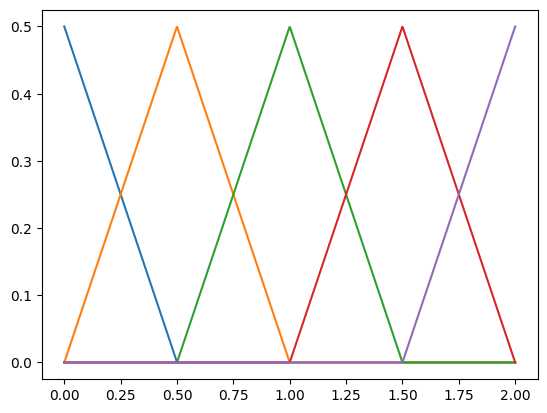

In [249]:
# Hat Functions

def hat(x, shift=0):
    y = np.zeros_like(x)
    mask = np.logical_and(shift <= x, x <= shift + 1)
    y[mask] = 0.5 - abs(0.5 - x[mask] + shift)
    return y

x = np.linspace(0, 2, 1000)

for shift in range(5):
    plt.plot(x, hat(x, shift / 2 - 0.5))


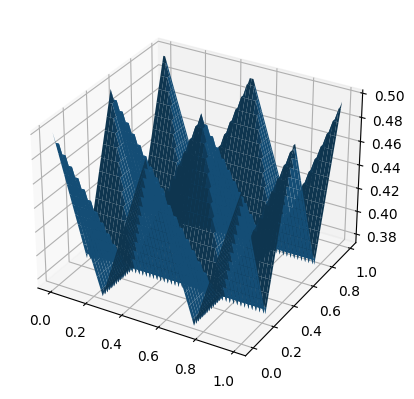

In [250]:
def hat_2d(x, y, shift_x=0, shift_y=0):
    z = np.maximum(0, 1 - np.maximum(abs(x-shift_x), abs(y-shift_y)))/2
    return z

x, y = np.mgrid[0:1:0.01, 0:1:0.01]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

z = np.zeros_like(x)
for shift_x in np.arange(0, 1.5, 0.5):
    for shift_y in np.arange(0, 1.5, 0.5):
        zed = hat_2d(x, y, shift_x, shift_y)
        z = np.maximum(z, zed)

ax.plot_surface(x, y, z)
plt.show()

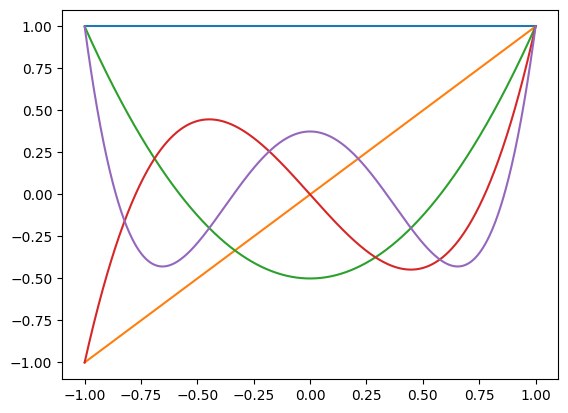

In [251]:
# Legendre Polynomials

# Bonnet's recursion formula
n = 5
P = np.zeros((2, n))
P[0, 0] = P[1, 1] = 1
for i in range(2, n):
    P = np.r_[P, [((2*i - 1)*np.roll(P[-1], 1) - (i-1)*P[-2]) / i]]

# Plot
x = np.linspace(-1, 1, 1000)
y = P @ [x**i for i in range(n)]
plt.plot(np.stack([x]*(n)).T, y.T)
plt.show()

In [252]:
xi, w = scipy.special.roots_legendre(n+1)
xi = [xi**i for i in range(n)]
def inner(Pi, Pj):
    return np.sum((Pi @ xi) * (Pj @ xi) * w)

In [253]:
# Finite element matrix
A = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = inner(P[i], P[j])

with np.printoptions(precision=2, suppress=True):
    print(A)

[[ 2.    0.   -0.    0.    0.  ]
 [ 0.    0.67 -0.   -0.    0.  ]
 [-0.   -0.    0.4   0.    0.  ]
 [ 0.   -0.    0.    0.29  0.  ]
 [ 0.    0.    0.    0.    0.22]]


In [254]:
# Finite element matrix for Poisson equation
P_diff = np.roll(np.arange(n) * P, -1) # first derivative
P_diff2 = np.roll(np.arange(n) * P_diff, -1) # second derivative
A = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = inner(P[i], P_diff2[j])

with np.printoptions(precision=2, suppress=True):
    print(A)
# No way to find constant/linear term, because u'' zeros them out. Would need boundary conditions.

[[ 0.  0.  6.  0. 20.]
 [ 0.  0. -0. 10. -0.]
 [ 0.  0. -0. -0. 14.]
 [ 0.  0.  0. -0.  0.]
 [ 0.  0.  0.  0.  0.]]


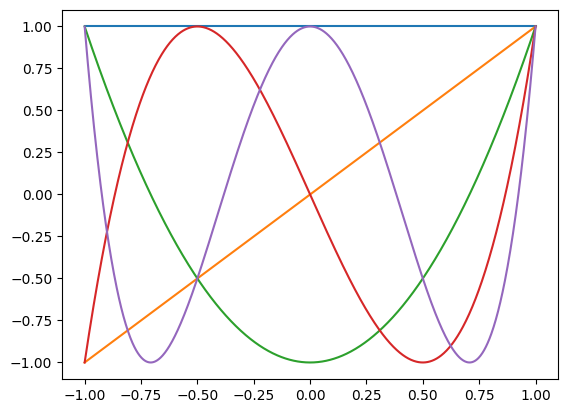

In [255]:
# Chebyshev Polynomials

# Recurrence formula
n = 5
T = np.zeros((2, n))
T[0, 0] = T[1, 1] = 1
for i in range(2, n):
    T = np.r_[T, [2*np.roll(T[-1], 1) - T[-2]]]
    

# Plot
x = np.linspace(-1, 1, 1000)
y = T @ [x**i for i in range(n)]
plt.plot(np.stack([x]*(n)).T, y.T)
plt.show()

In [256]:
xi, w = scipy.special.roots_chebyt(n+1)
xi = [xi**i for i in range(n)]
def inner(Ti, Tj):
    return np.sum((Ti @ xi) * (Tj @ xi) * w, axis=-1)

In [257]:
# Finite element matrix
A = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = inner(T[i], T[j])

with np.printoptions(precision=2, suppress=True):
    print(A)

[[ 3.14  0.   -0.    0.    0.  ]
 [ 0.    1.57  0.   -0.    0.  ]
 [-0.    0.    1.57  0.    0.  ]
 [ 0.   -0.    0.    1.57 -0.  ]
 [ 0.    0.    0.   -0.    1.57]]


In [258]:
# Finite element matrix for 1D Poisson equation

T_diff1 = np.roll(np.arange(n) * T, -1) # first derivative
T_diff2 = np.roll(np.arange(n) * T_diff1, -1) # second derivative
A = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = inner(T[i], T_diff2[j])

with np.printoptions(precision=2, suppress=True):
    print(A)

[[  0.     0.    12.57  -0.   100.53]
 [  0.     0.     0.    37.7    0.  ]
 [  0.     0.    -0.     0.    75.4 ]
 [  0.     0.     0.    -0.     0.  ]
 [  0.     0.     0.     0.     0.  ]]


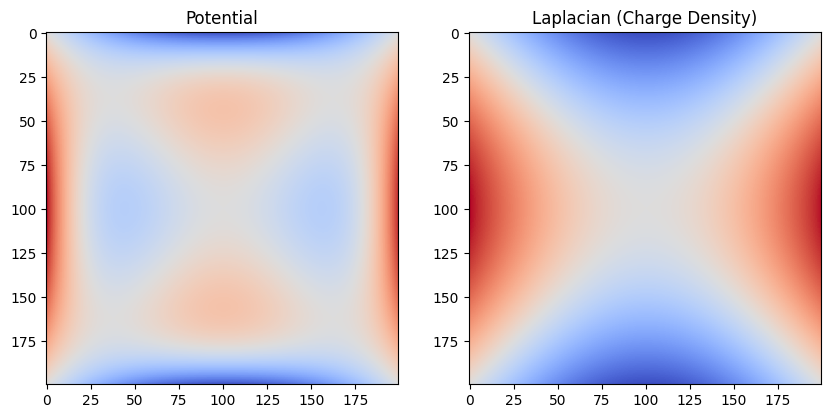

In [306]:
# 2D Poisson Equation

"""
Interior
--------

We directly evaluate the n^2 x n^2 inner products

〈Ψy〈Ψx, Φx〉Φy〉=〈Ψx, Φx〉*〈Ψy, Φy〉

(we chose a separable basis).
"""

diff_x = [inner(Ti, Tj) for Ti in T_diff2 for Tj in T]
diff_y = [inner(Ti, Tj) for Ti in T for Tj in T_diff2]
no_diff = [inner(Ti, Tj) for Ti in T for Tj in T]
A = np.outer(no_diff, diff_x) + np.outer(no_diff, diff_y)
b = np.zeros(n**2)

"""
Boundaries
----------

We're putting charges of ±1 along the edges. Evaluating at x=±1 gives the left boundary condition:

    ±1 = Σ〈Ψx(-1)Ψy(y), Φx(-1)Φy(y)''〉= Σ〈Ψy, Φy''〉

as

    Tn(±1) = (±1)^n => Ψx(±1)Φx(±1) = 1.

Similarly, the top and bottom boundary conditions are
    
    ±1 = Σ〈Ψx, Φx〉.

To keep it smooth, we also want the derivatives to evaluate to zero:

    Σ〈Ψx, Φx⁽ᵏ⁾〉= Σ〈Ψy, Φy⁽ᵏ⁾〉= 0, k ≥ 1.

"""

A = np.pad(A, [(4*n, 0), (0, 0)])
b = np.pad(b, (4*n, 0))

# Set charges
A_1d = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        A_1d[i, j] = inner(T[i], T_diff2[j])

ones = np.ones(n)
negs = (-1)**np.arange(n)
A[0*n:1*n] = np.einsum('ij,k->ijk', A_1d, ones).reshape(n, n**2) # right
A[1*n:2*n] = np.einsum('ij,k->ijk', A_1d, negs).reshape(n, n**2) # left
A[2*n:3*n] = np.einsum('ij,k->ikj', A_1d, ones).reshape(n, n**2) # bottom
A[3*n:4*n] = np.einsum('ij,k->ikj', A_1d, negs).reshape(n, n**2) # top

c = np.array([1] + [0]*(n-1))
Q = inner(T, c)
        
b[0*n:1*n] = Q # right
b[1*n:2*n] = Q # left
b[2*n:3*n] = -Q # bottom
b[3*n:4*n] = -Q # top


# Solve for coefficients
c = np.linalg.lstsq(A, b, rcond=None)[0]
c = c.reshape((n, n))

def u(x, y):
    x = np.array([x**i for i in range(n)])
    y = np.array([y**i for i in range(n)])
    x = np.einsum('ij,jxy->ixy', T, x)
    y = np.einsum('ij,jxy->ixy', T, y)
    return np.einsum('ixy,ij,jxy->xy', x, c, y)

def laplacian(x, y):
    x = np.array([x**i for i in range(n)])
    y = np.array([y**i for i in range(n)])
    dx = np.einsum('ij,jxy->ixy', T_diff2, x)
    dy = np.einsum('ij,jxy->ixy', T_diff2, y)
    x = np.einsum('ij,jxy->ixy', T, x)
    y = np.einsum('ij,jxy->ixy', T, y)
    return np.einsum('ixy,ij,jxy->xy', dx, c, y) + np.einsum('ixy,ij,jxy->xy', x, c, dy)

x, y = np.mgrid[-1:1:0.01, -1:1:0.01]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Potential")
axes[1].set_title("Laplacian (Charge Density)")
im0 = axes[0].imshow(u(x, y).T, cmap="coolwarm")
im1 = axes[1].imshow(laplacian(x, y).T, cmap="coolwarm")
plt.show()

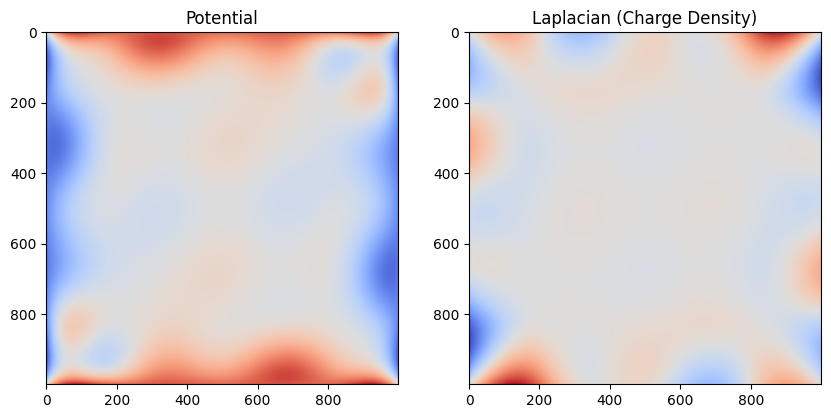

In [394]:
# 2D Poisson Equation, meshed

mesh_size = 5
smoothness = 3

"""
Meshing
-------

We create a mesh_size x mesh_size grid. Between cells we set the derivatives equal in both the x and y direction.
Indexing becomes a little trickier.

Also, I chose Dirichlet boundaries for the potential instead of setting charges. The code isn't very different,
it just looks prettier.
"""

# Interior
diff_x = [inner(Ti, Tj) for Ti in T_diff2 for Tj in T]
diff_y = [inner(Ti, Tj) for Ti in T for Tj in T_diff2]
no_diff = [inner(Ti, Tj) for Ti in T for Tj in T]

m = mesh_size
A = np.outer(no_diff, diff_x) + np.outer(no_diff, diff_y)
A = scipy.linalg.block_diag(*[A for i in range(m**2)])
b = np.zeros(n**2*m**2)


# Boundaries
s = smoothness + 1
A = np.pad(A, [(4 * s**2 * n * m**2, 0), (0, 0)])
b = np.pad(b, (4 * s**2 * n * m**2, 0))

T_diff = [T]
for i in range(s-1):
    T_diff.append(np.roll(np.arange(n) * T_diff[-1], -1))

for k in range(s):
    for k2 in range(s):
        A_1d = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                A_1d[i, j] = inner(T[i], T_diff[k][j])

        ones = T_diff[k2] @ np.ones(n)
        negs = T_diff[k2] @ (-1)**np.arange(n)

        # Derivatives:
        right = np.einsum('ij,k->ijk', A_1d, ones).reshape(n, n**2)
        left = np.einsum('ij,k->ijk', A_1d, negs).reshape(n, n**2)
        bottom = np.einsum('ij,k->ikj', A_1d, ones).reshape(n, n**2)
        top = np.einsum('ij,k->ikj', A_1d, negs).reshape(n, n**2)

        for x in range(m):
            for y in range(m):
                i = 4*k*n + 4*n*s*(x+y*m) + 4*s*n*m**2*k2
                j = n**2*(x+y*m)

                if x < m-1: # right boundary
                    A[i:i+n, j:j+n**2] += right
                    A[i:i+n, j+n**2:j+2*n**2] += -left

                i += n
                if x > 0: # left boundary
                    A[i:i+n, j:j+n**2] += left
                    A[i:i+n, j-n**2:j] += -right

                i += n
                if y < m-1: # bottom boundary
                    A[i:i+n, j:j+n**2] = bottom
                    A[i:i+n, j+m*n**2:j+(m+1)*n**2] += -top

                i += n
                if y > 0: # top boundary
                    A[i:i+n, j:j+n**2] = top
                    A[i:i+n, j-m*n**2:j-(m-1)*n**2] += -bottom

# Set Dirichlet boundaries
k = 0
A_1d = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        A_1d[i, j] = inner(T[i], T[j])

ones = np.ones(n)
negs = (-1)**np.arange(n)

right = np.einsum('ij,k->ijk', A_1d, ones).reshape(n, n**2)
left = np.einsum('ij,k->ijk', A_1d, negs).reshape(n, n**2)
bottom = np.einsum('ij,k->ikj', A_1d, ones).reshape(n, n**2)
top = np.einsum('ij,k->ikj', A_1d, negs).reshape(n, n**2)

c = np.array([1] + [0]*(n-1))
Q = inner(T, c)
for y in range(m):
    i = n + 4*k*n + 4*n*s*y*m
    j = n**2*y*m
    A[i:i+n, j:j+n**2] += left
    b[i:i+n] += Q

    i += -n + 4*n*s*(m-1)
    j += n**2*(m-1)
    A[i:i+n, j:j+n**2] += right
    b[i:i+n] += Q

for x in range(m):
    i = 3*n + 4*k*n + 4*n*s*x
    j = n**2*x

    A[i:i+n, j:j+n**2] += top
    b[i:i+n] += -Q

    i += -n + 4*n*s*m*(m-1)
    j += n**2*m*(m-1)

    A[i:i+n, j:j+n**2] += bottom
    b[i:i+n] += -Q

# Solve for coefficients
c = np.linalg.lstsq(A, b, rcond=None)[0]
c = c.reshape((m, m, n, n))

def u(x, y):
    x = np.array([x**i for i in range(n)])
    y = np.array([y**i for i in range(n)])
    x = np.einsum('ij,jxy->ixy', T, x)
    y = np.einsum('ij,jxy->ixy', T, y)
    
    t = []
    for a in range(m):
        t += [[]]
        for b in range(m):
            t[-1] += [np.einsum('ixy,ij,jxy->xy', x, c[a, b], y)]
        t[-1] = np.hstack(t[-1])
    t = np.vstack(t)
    return t

def laplacian(x, y):
    x = np.array([x**i for i in range(n)])
    y = np.array([y**i for i in range(n)])
    dx = np.einsum('ij,jxy->ixy', T_diff2, x)
    dy = np.einsum('ij,jxy->ixy', T_diff2, y)
    x = np.einsum('ij,jxy->ixy', T, x)
    y = np.einsum('ij,jxy->ixy', T, y)
    
    t = []
    for a in range(m):
        t += [[]]
        for b in range(m):
            t[-1] += [np.einsum('ixy,ij,jxy->xy', dx, c[a, b], y) + \
                      np.einsum('ixy,ij,jxy->xy', x, c[a, b], dy)]
        t[-1] = np.hstack(t[-1])
    t = np.vstack(t)
    return t

x, y = np.mgrid[-1:1:0.01, -1:1:0.01]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Potential")
axes[1].set_title("Laplacian (Charge Density)")

im0 = axes[0].imshow(u(x, y).T, cmap="coolwarm")
im1 = axes[1].imshow(laplacian(x, y).T, cmap="coolwarm")
plt.show()

In [14]:
# Fast Fourier Transform
# see https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm

def fft(x, inverse=False):
    if bin(len(x)).count('1') > 1:
        raise "You must pad x so the number of elements is a power of two."
    
    N = len(x)
    if N == 1:
        return x
    
    w = np.exp(-2j*np.pi/N) ** np.arange(N//2)
    if inverse:
        w = w.conj()
    
    y = fft(x[::2], inverse=inverse)
    z = fft(x[1::2], inverse=inverse)
    return np.r_[y + w * z, y - w * z]

ifft = lambda x: fft(x, inverse=True) / len(x)

# Multiply two polynomials together.

a = np.array([1, 1, 1, 1, 0, 0, 0, 0]) # 1 + x + x^2 + x^3
b = np.array([1, 2, 3, 4, 0, 0, 0, 0]) # 1 + 2x + 3x^2 + 4x^3
c = ifft(fft(a) * fft(b)).real

with np.printoptions(precision=2, suppress=True):
    print("a(x)        = 1x^0 + 1x^1 + 1x^2 + 1x^3")
    print("b(x)        = 1x^0 + 2x^1 + 3x^2 + 4x^3")
    print("a(x) * b(x) =", " + ".join(f"{c:.0f}x^{i}" for i, c in enumerate(c)))

a(x)        = 1x^0 + 1x^1 + 1x^2 + 1x^3
b(x)        = 1x^0 + 2x^1 + 3x^2 + 4x^3
a(x) * b(x) = 1x^0 + 3x^1 + 6x^2 + 10x^3 + 9x^4 + 7x^5 + 4x^6 + 0x^7


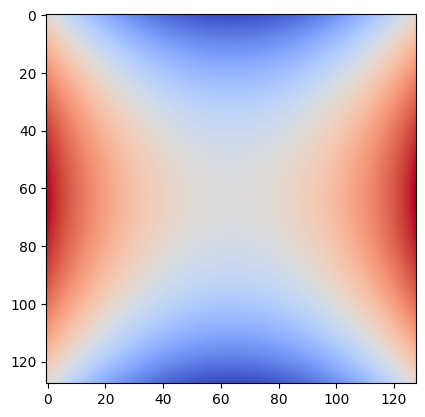

In [15]:
# Solving the Poisson Equation
def fft2d(x, inverse=False):
    if bin(len(x)).count('1') > 1:
        raise Exception("You must pad x so the number of elements is a power of two.")
    
    N = len(x)
    if N == 1:
        return [fft(x[0], inverse=inverse)]
    
    w = np.exp(-2j*np.pi*np.arange(N//2)/N)[:, None]
    if inverse:
        w = w.conj()
    
    y = fft2d(x[::2], inverse=inverse)
    z = fft2d(x[1::2], inverse=inverse)
    return np.r_[y + w * z, y - w * z]

ifft2d = lambda x: fft2d(x, inverse=True) / np.prod(x.shape)

N = 128
f = np.zeros((N, N))
f[0, :] = f[-1, :] = 1
f[:, 0] = f[:, -1] = -1

# Perform magic in Fourier space
U = fft2d(f)
c = np.cos(2*np.pi*np.arange(N) / N)
c = 2*np.add.outer(c, c) - 4
c *= N**2
np.divide(U, c, out=U, where=(c!=0))

# Transform back
u = ifft2d(U).real
plt.imshow(u, cmap="coolwarm");

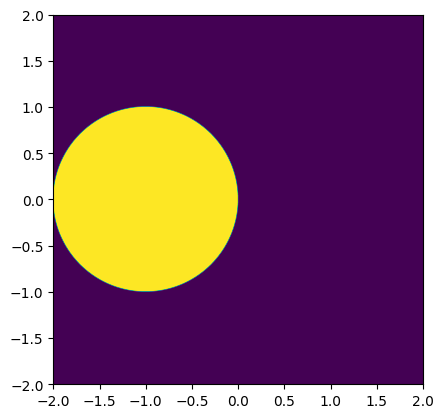

In [16]:
# Euler's Method Stability Region

z = np.mgrid[-2:2:0.001, -2:2:0.001]
z = z[1] + 1j * z[0]
mask = abs(1 + z) < 1
plt.imshow(mask, extent=[-2, 2, -2, 2])

In [17]:
# Stability Example w/ Heat Equation.

stencil = [[0,  1,  0],
           [1, -4,  1],
           [0,  1,  0]]

def animate(N, dt):
    u = np.zeros((N, N))
    u[[0, -1], :] += 1
    u[:, [0, -1]] -= 1
    
    def step(*args):
        nonlocal u
        u = u + dt * scipy.signal.convolve2d(u, stencil, 'same') * np.prod(u.shape)

        im.set_array(u)
        return im,

    fig = plt.figure()
    im = plt.imshow(u, animated=True, cmap="coolwarm")

    ani = animation.FuncAnimation(fig, step, frames=50, interval=100, blit=False, repeat=False)

    html_video = HTML(ani.to_jshtml())
    plt.close()
    display(html_video)

In [18]:
N = 21
dt = 1 / 4 / N**2 + 1e-4 # Just barely too large a time step large.
animate(N, dt)

In [19]:
dt = 1 / 4 / N**2 # Just barely small enough.
animate(N, dt)